<a href="https://colab.research.google.com/github/ManojKurapati/Audio_synthesis_Neuralnetwork/blob/main/youtube_transcriber_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title GPU + deps
!nvidia-smi -L || true
!pip -q install yt-dlp pydub matplotlib tqdm

import torch, torchaudio, platform
print("Torch:", torch.__version__, "| Torchaudio:", torchaudio.__version__, "| Python:", platform.python_version())

GPU 0: Tesla T4 (UUID: GPU-49da7e62-4d54-2199-1243-2997455bd494)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 108.6 MB/s eta 0:00:00
Torch: 2.6.0+cu124 | Torchaudio: 2.6.0+cu124 | Python: 3.11.13


In [ ]:
import os, json, time, math, copy, argparse, random
from dataclasses import dataclass, asdict
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchaudio
from torchaudio.datasets import YESNO
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def nowdir(prefix="runs"):
    import datetime as dt
    ts = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
    out = os.path.join(prefix, ts)
    os.makedirs(out, exist_ok=True)
    return out

def save_jsonl(path: str, record: Dict):
    with open(path, "a") as f:
        f.write(json.dumps(record) + "\n")

@dataclass
class Config:
    data_root: str = "./data"
    sample_rate: int = 16000
    n_mels: int = 80
    n_fft: int = 400
    hop_length: int = 160
    win_length: int = 400
    epochs: int = 15
    batch_size: int = 16
    lr: float = 2e-3
    weight_decay: float = 1e-4
    hidden_size: int = 256
    num_layers: int = 3
    dropout: float = 0.1
    grad_clip: float = 5.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 2
    seed: int = 42
    log_every: int = 50

cfg = Config()
cfg


Config(data_root='./data', sample_rate=16000, n_mels=80, n_fft=400, hop_length=160, win_length=400, epochs=15, batch_size=16, lr=0.002, weight_decay=0.0001, hidden_size=256, num_layers=3, dropout=0.1, grad_clip=5.0, device='cuda', num_workers=2, seed=42, log_every=50)

In [ ]:
class CharTokenizer:
    """Char-level tokenizer for CTC. idx 0 reserved for <blank>.
       Lowercases text; unknowns -> space."""
    def __init__(self, vocab: str):
        self.vocab = ["<blank>"] + list(vocab)
        self.char2idx = {c: i for i, c in enumerate(self.vocab)}
        self.blank_id = 0

    @staticmethod
    def build_from_corpus(texts: List[str]):
        allowed = set(list("abcdefghijklmnopqrstuvwxyz0123456789 '.,?!-:;()"))
        chars = set()
        for t in texts:
            for ch in t.lower():
                if ch in allowed:
                    chars.add(ch)
                elif ch == "\t":
                    continue
                else:
                    chars.add(" ")
        chars.add(" ")
        vocab = "".join(sorted(list(chars)))
        return CharTokenizer(vocab)

    def encode(self, text: str) -> List[int]:
        text = text.lower()
        out = []
        for ch in text:
            if ch not in self.char2idx: ch = " "
            out.append(self.char2idx[ch])
        return out

    def decode(self, ids: List[int], collapse_repeats=True) -> str:
        res, prev = [], None
        for i in ids:
            if i == self.blank_id:
                prev = None
                continue
            if collapse_repeats and i == prev:
                continue
            res.append(self.vocab[i])
            prev = i
        return "".join(res).strip()

    @property
    def vocab_size(self): return len(self.vocab)


In [ ]:
class MelSpecExtractor(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.mel = MelSpectrogram(
            sample_rate=cfg.sample_rate,
            n_fft=cfg.n_fft, hop_length=cfg.hop_length, win_length=cfg.win_length,
            n_mels=cfg.n_mels, power=2.0, normalized=False, center=True
        )
        self.db = AmplitudeToDB(stype="power")

    @torch.no_grad()
    def forward(self, wav: torch.Tensor, sr: int) -> torch.Tensor:
        if sr != self.cfg.sample_rate:
            wav = torchaudio.functional.resample(wav, sr, self.cfg.sample_rate)
        feat = self.db(self.mel(wav))  # (n_mels, T)
        mean = feat.mean(dim=-1, keepdim=True)
        std  = feat.std(dim=-1, keepdim=True).clamp_min(1e-5)
        return (feat - mean) / std

class AN4Wrap(torch.utils.data.Dataset):
    def __init__(self, dataset, extractor: MelSpecExtractor, tokenizer: CharTokenizer):
        self.ds = dataset; self.ext = extractor; self.tok = tokenizer

    def __len__(self): return len(self.ds)

    def __getitem__(self, idx: int):
        wav, sr, transcript, speaker_id, utt_id = self.ds[idx]
        feat = self.ext(wav, sr)                     # (n_mels, T)
        target = torch.tensor(self.tok.encode(transcript), dtype=torch.long)
        return feat, transcript, target

def collate_fn(batch):
    batch = sorted(batch, key=lambda x: x[0].shape[-1], reverse=True)
    feats, texts, targets = zip(*batch)
    input_lengths = torch.tensor([f.shape[-1] for f in feats], dtype=torch.long)
    target_lengths = torch.tensor([t.numel() for t in targets], dtype=torch.long)
    n_mels = feats[0].shape[0]
    max_T = int(max([f.shape[-1] for f in feats]))
    feat_pad = torch.zeros(len(feats), n_mels, max_T, dtype=torch.float32)
    for i, f in enumerate(feats): feat_pad[i, :, : f.shape[-1]] = f
    targets_cat = torch.cat(targets, dim=0)
    return feat_pad, input_lengths, targets_cat, target_lengths, list(texts)


In [ ]:
class CTCBiGRU(nn.Module):
    def __init__(self, n_mels: int, hidden: int, layers: int, dropout: float, vocab_size: int):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=n_mels, hidden_size=hidden, num_layers=layers,
            batch_first=True, bidirectional=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden * 2, vocab_size)

    def forward(self, feats: torch.Tensor, lengths: torch.Tensor):
        x = feats.transpose(1, 2)                            # (B,T,n_mels)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)
        out, _ = self.rnn(packed)
        out, _ = pad_packed_sequence(out, batch_first=True)  # (B,T,2H)
        logits = self.fc(out).transpose(0, 1)                # (T,B,V)
        return logits, lengths

def _edit_distance(a: List[str], b: List[str]) -> int:
    m, n = len(a), len(b)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1): dp[i][0] = i
    for j in range(n+1): dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1]+cost)
    return dp[m][n]

def cer(ref: str, hyp: str) -> float:
    rc, hc = list(ref.strip().lower()), list(hyp.strip().lower())
    return 0.0 if len(rc)==0 and len(hc)==0 else _edit_distance(rc, hc)/max(1,len(rc))

def wer(ref: str, hyp: str) -> float:
    rw, hw = ref.strip().lower().split(), hyp.strip().lower().split()
    return 0.0 if len(rw)==0 and len(hw)==0 else _edit_distance(rw, hw)/max(1,len(rw))

def greedy_decode(logits: torch.Tensor, blank_id: int = 0) -> List[int]:
    ids = logits.argmax(dim=-1).tolist()
    out, prev = [], None
    for i in ids:
        if i == blank_id: prev = None; continue
        if i == prev: continue
        out.append(i); prev = i
    return out


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device, tokenizer, log_every=50):
    model.train()
    total_loss, steps = 0.0, 0
    t0 = time.time()
    for step, (feats, in_lens, tgts, tgt_lens, texts) in enumerate(loader, 1):
        feats, in_lens, tgts, tgt_lens = feats.to(device), in_lens.to(device), tgts.to(device), tgt_lens.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=device.startswith("cuda")):
            logits, out_lens = model(feats, in_lens)
            loss = criterion(logits.log_softmax(2), tgts, out_lens, tgt_lens)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item(); steps += 1
        if step % log_every == 0:
            dt = time.time() - t0
            print(f"  step {step:05d} | loss {total_loss/steps:.4f} | dt {dt:.1f}s")
            t0 = time.time()
    return total_loss / max(1, steps)

@torch.no_grad()
def evaluate(model, loader, criterion, device, tokenizer):
    model.eval()
    tot_loss, n_batches = 0.0, 0
    tot_cer, tot_wer, n_utts = 0.0, 0.0, 0
    for feats, in_lens, tgts, tgt_lens, texts in loader:
        feats, in_lens, tgts, tgt_lens = feats.to(device), in_lens.to(device), tgts.to(device), tgt_lens.to(device)
        logits, out_lens = model(feats, in_lens)
        loss = criterion(logits.log_softmax(2), tgts, out_lens, tgt_lens)
        tot_loss += loss.item(); n_batches += 1

        T,B,V = logits.shape
        for b in range(B):
            seq = logits[:, b, :]
            ids = greedy_decode(seq, blank_id=tokenizer.blank_id)
            hyp = tokenizer.decode(ids)
            ref = texts[b]
            tot_cer += cer(ref, hyp)
            tot_wer += wer(ref, hyp)
            n_utts += 1

    return (tot_loss/max(1,n_batches),
            tot_cer/max(1,n_utts),
            tot_wer/max(1,n_utts))


In [ ]:
import os
os.makedirs(cfg.data_root, exist_ok=True)  # ensure the data directory exists

set_seed(cfg.seed)
device = cfg.device
print("Device:", device)

outdir = nowdir("runs"); print("Saving to:", outdir)

from torch.utils.data import random_split, DataLoader

_tmp = YESNO(root=cfg.data_root, download=True)
corpus = [
    " ".join("yes" if int(x)==1 else "no" for x in labels)
    for (_, _, labels) in _tmp
]

# Tokenizer
tokenizer = CharTokenizer.build_from_corpus(corpus)
print("Vocab size:", tokenizer.vocab_size)

# Inline wrapper for YESNO to produce (features, transcript, target_ids)
class YesNoWrap(torch.utils.data.Dataset):
    def __init__(self, root, download, extractor, tokenizer):
        self.ds = YESNO(root=root, download=download)
        self.ext = extractor
        self.tok = tokenizer
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        wav, sr, labels = self.ds[idx]
        transcript = " ".join("yes" if int(x)==1 else "no" for x in labels)
        feat = self.ext(wav, sr)  # (n_mels, T)
        feat = feat.squeeze(0) if feat.dim() == 3 else feat  # Ensure 2D
        if feat.shape[0] != cfg.n_mels:
            # Adjust mel dimension if mismatch
            feat = torch.nn.functional.interpolate(feat.unsqueeze(0), size=(cfg.n_mels, feat.shape[1]), mode='bilinear', align_corners=False).squeeze(0)
        target = torch.tensor(self.tok.encode(transcript), dtype=torch.long)
        return feat, transcript, target

# Feature extractor & dataset
extractor = MelSpecExtractor(cfg)
full_ds = YesNoWrap(root=cfg.data_root, download=False, extractor=extractor, tokenizer=tokenizer)

# Train/Val split 80/20
n = len(full_ds)
n_train = int(0.8 * n)
n_val = n - n_train
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(cfg.seed))

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=0, collate_fn=collate_fn, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=0, collate_fn=collate_fn, pin_memory=True)

# --- Model / Optim / Loss ---
model = CTCBiGRU(cfg.n_mels, cfg.hidden_size, cfg.num_layers, cfg.dropout, tokenizer.vocab_size).to(device)
optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
criterion = nn.CTCLoss(blank=tokenizer.blank_id, zero_infinity=True)
scaler = torch.cuda.amp.GradScaler(enabled=device.startswith("cuda"))

best_cer = float("inf")
metrics_path = os.path.join(outdir, "metrics.jsonl")

for epoch in range(1, cfg.epochs+1):
    print(f"\nEpoch {epoch}/{cfg.epochs}")
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, tokenizer, cfg.log_every)
    val_loss, val_cer, val_wer = evaluate(model, val_loader, criterion, device, tokenizer)
    char_acc = 1.0 - val_cer
    rec = {"epoch": epoch, "train_loss": tr_loss, "val_loss": val_loss,
           "val_cer": val_cer, "val_wer": val_wer, "char_accuracy": char_acc}
    save_jsonl(metrics_path, rec)
    print(f"  train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | CER={val_cer:.3f} | WER={val_wer:.3f} | CharAcc={char_acc:.3f}")

    ckpt = {
        "model_state": model.state_dict(),
        "config": asdict(cfg),
        "tokenizer_vocab": "".join(tokenizer.vocab[1:]),
        "blank_id": tokenizer.blank_id,
    }
    torch.save(ckpt, os.path.join(outdir, "last.ckpt"))
    if val_cer < best_cer:
        best_cer = val_cer
        torch.save(ckpt, os.path.join(outdir, "best.ckpt"))
        print(f"  ✅ New best CER={best_cer:.3f} -> saved best.ckpt")


Device: cuda
Saving to: runs/20250811-123745


100%|██████████| 4.49M/4.49M [00:01<00:00, 2.43MB/s]


Vocab size: 7


/tmp/ipython-input-670550748.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.startswith("cuda"))



Epoch 1/15


/tmp/ipython-input-3054475909.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.startswith("cuda")):


  train_loss=36.2670 | val_loss=37.0590 | CER=0.905 | WER=1.052 | CharAcc=0.095
  ✅ New best CER=0.905 -> saved best.ckpt

Epoch 2/15
  train_loss=18.2267 | val_loss=5.1383 | CER=0.965 | WER=1.000 | CharAcc=0.035

Epoch 3/15
  train_loss=4.6777 | val_loss=4.5976 | CER=0.621 | WER=1.000 | CharAcc=0.379
  ✅ New best CER=0.621 -> saved best.ckpt

Epoch 4/15
  train_loss=3.6893 | val_loss=2.3717 | CER=0.463 | WER=1.021 | CharAcc=0.537
  ✅ New best CER=0.463 -> saved best.ckpt

Epoch 5/15
  train_loss=1.9628 | val_loss=2.0811 | CER=0.511 | WER=0.865 | CharAcc=0.489

Epoch 6/15
  train_loss=1.6848 | val_loss=1.7045 | CER=0.461 | WER=0.854 | CharAcc=0.539
  ✅ New best CER=0.461 -> saved best.ckpt

Epoch 7/15
  train_loss=1.3720 | val_loss=1.4762 | CER=0.579 | WER=0.865 | CharAcc=0.421

Epoch 8/15
  train_loss=1.3054 | val_loss=1.3371 | CER=0.429 | WER=0.812 | CharAcc=0.571
  ✅ New best CER=0.429 -> saved best.ckpt

Epoch 9/15
  train_loss=1.2303 | val_loss=1.4007 | CER=0.489 | WER=0.750 | Cha

In [ ]:
import os
os.makedirs(cfg.data_root, exist_ok=True)  # ensure the data directory exists

set_seed(cfg.seed)
device = cfg.device
print("Device:", device)

outdir = nowdir("runs"); print("Saving to:", outdir)

# --- Use torchaudio YESNO dataset ---
from torch.utils.data import random_split, DataLoader
from torchaudio.datasets import YESNO # Import YESNO dataset

# Build corpus ("yes"/"no" tokens) for tokenizer
_tmp = YESNO(root=cfg.data_root, download=True)
corpus = [
    " ".join("yes" if int(x)==1 else "no" for x in labels)
    for (_, _, labels) in _tmp
]

# Tokenizer
tokenizer = CharTokenizer.build_from_corpus(corpus)
print("Vocab size:", tokenizer.vocab_size)

# Inline wrapper for YESNO to produce (features, transcript, target_ids)
class YesNoWrap(torch.utils.data.Dataset):
    def __init__(self, dataset, extractor, tokenizer):
        self.ds = dataset
        self.ext = extractor
        self.tok = tokenizer
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        wav, sr, labels = self.ds[idx]
        transcript = " ".join("yes" if int(x)==1 else "no" for x in labels)
        feat = self.ext(wav, sr)  # (n_mels, T)
        # Ensure feature is 2D (n_mels, T)
        feat = feat.squeeze(0) if feat.dim() == 3 else feat
        if feat.shape[0] != cfg.n_mels:
            # Adjust mel dimension if mismatch - this might not be the best approach,
            # but it attempts to handle potential shape inconsistencies.
            # A better approach might be to ensure the extractor produces the correct shape.
            # For now, let's try to interpolate if needed.
            try:
                feat = torch.nn.functional.interpolate(feat.unsqueeze(0), size=(cfg.n_mels, feat.shape[1]), mode='bilinear', align_corners=False).squeeze(0)
            except RuntimeError:
                 # Fallback if interpolation fails (e.g., time dimension is 1)
                 print(f"Warning: Could not interpolate feature shape for index {idx}. Expected {cfg.n_mels}, got {feat.shape[0]}. Skipping interpolation.")
                 # You might want to handle this case differently, e.g., pad or skip the sample
                 pass # For now, just pass and hope the rest of the pipeline can handle it


        target = torch.tensor(self.tok.encode(transcript), dtype=torch.long)
        return feat, transcript, target

# Feature extractor & dataset
extractor = MelSpecExtractor(cfg)
# Load the YESNO dataset without downloading again if already present
full_ds = YESNO(root=cfg.data_root, download=False)
wrapped_ds = YesNoWrap(dataset=full_ds, extractor=extractor, tokenizer=tokenizer)


# Train/Val split 80/20
n = len(wrapped_ds)
n_train = int(0.8 * n)
n_val = n - n_train
train_ds, val_ds = random_split(wrapped_ds, [n_train, n_val], generator=torch.Generator().manual_seed(cfg.seed))


train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=0, collate_fn=collate_fn, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=0, collate_fn=collate_fn, pin_memory=True)


# --- Model / Optim / Loss ---
model = CTCBiGRU(cfg.n_mels, cfg.hidden_size, cfg.num_layers, cfg.dropout, tokenizer.vocab_size).to(device)
optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
criterion = nn.CTCLoss(blank=tokenizer.blank_id, zero_infinity=True)
scaler = torch.cuda.amp.GradScaler(enabled=device.startswith("cuda"))

best_cer = float("inf")
metrics_path = os.path.join(outdir, "metrics.jsonl")

for epoch in range(1, cfg.epochs+1):
    print(f"\nEpoch {epoch}/{cfg.epochs}")
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, tokenizer, cfg.log_every)
    val_loss, val_cer, val_wer = evaluate(model, val_loader, criterion, device, tokenizer)
    char_acc = 1.0 - val_cer
    rec = {"epoch": epoch, "train_loss": tr_loss, "val_loss": val_loss,
           "val_cer": val_cer, "val_wer": val_wer, "char_accuracy": char_acc}
    save_jsonl(metrics_path, rec)
    print(f"  train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | CER={val_cer:.3f} | WER={val_wer:.3f} | CharAcc={char_acc:.3f}")

    ckpt = {
        "model_state": model.state_dict(),
        "config": asdict(cfg),
        "tokenizer_vocab": "".join(tokenizer.vocab[1:]),
        "blank_id": tokenizer.blank_id,
    }
    torch.save(ckpt, os.path.join(outdir, "last.ckpt"))
    if val_cer < best_cer:
        best_cer = val_cer
        torch.save(ckpt, os.path.join(outdir, "best.ckpt"))
        print(f"  ✅ New best CER={best_cer:.3f} -> saved best.ckpt")

Device: cuda
Saving to: runs/20250811-124401
Vocab size: 7

Epoch 1/15


/tmp/ipython-input-1732584801.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.startswith("cuda"))
/tmp/ipython-input-3054475909.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.startswith("cuda")):


  train_loss=36.2670 | val_loss=37.0590 | CER=0.905 | WER=1.052 | CharAcc=0.095
  ✅ New best CER=0.905 -> saved best.ckpt

Epoch 2/15
  train_loss=18.2267 | val_loss=5.1383 | CER=0.965 | WER=1.000 | CharAcc=0.035

Epoch 3/15
  train_loss=4.6777 | val_loss=4.5976 | CER=0.621 | WER=1.000 | CharAcc=0.379
  ✅ New best CER=0.621 -> saved best.ckpt

Epoch 4/15
  train_loss=3.6893 | val_loss=2.3717 | CER=0.463 | WER=1.021 | CharAcc=0.537
  ✅ New best CER=0.463 -> saved best.ckpt

Epoch 5/15
  train_loss=1.9628 | val_loss=2.0811 | CER=0.511 | WER=0.865 | CharAcc=0.489

Epoch 6/15
  train_loss=1.6848 | val_loss=1.7045 | CER=0.461 | WER=0.854 | CharAcc=0.539
  ✅ New best CER=0.461 -> saved best.ckpt

Epoch 7/15
  train_loss=1.3720 | val_loss=1.4762 | CER=0.579 | WER=0.865 | CharAcc=0.421

Epoch 8/15
  train_loss=1.3054 | val_loss=1.3371 | CER=0.429 | WER=0.812 | CharAcc=0.571
  ✅ New best CER=0.429 -> saved best.ckpt

Epoch 9/15
  train_loss=1.2303 | val_loss=1.4007 | CER=0.489 | WER=0.750 | Cha

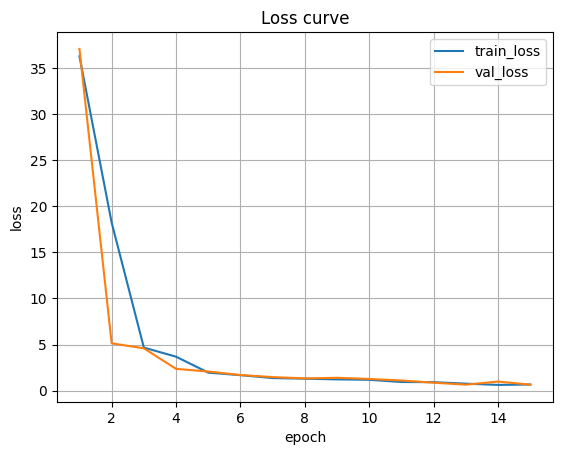

{'epoch': 15,
 'train_loss': 0.6754006147384644,
 'val_loss': 0.6556249260902405,
 'val_cer': 0.21669854836521504,
 'val_wer': 0.4479166666666667,
 'char_accuracy': 0.7833014516347849}

In [ ]:
#@title Plot loss curve
rows = [json.loads(x) for x in open(metrics_path)]
xs = [r["epoch"] for r in rows]
tr = [r["train_loss"] for r in rows]
vl = [r["val_loss"] for r in rows]
plt.figure()
plt.plot(xs, tr, label="train_loss")
plt.plot(xs, vl, label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss curve")
plt.grid(True); plt.show()
rows[-1]


In [ ]:
#@title Inference Helpers
import subprocess, tempfile, urllib.parse, requests

def download_media_to_wav(url: str, out_wav: str, sample_rate: int = 16000):
    ext = os.path.splitext(urllib.parse.urlparse(url).path)[1].lower()
    if ext in [".wav", ".mp3", ".m4a", ".flac", ".ogg"]:
        r = requests.get(url, timeout=60); r.raise_for_status()
        tmp = out_wav + ".tmp"
        with open(tmp, "wb") as f: f.write(r.content)
        wav, sr = torchaudio.load(tmp)
        if sr != sample_rate:
            wav = torchaudio.functional.resample(wav, sr, sample_rate)
        torchaudio.save(out_wav, wav, sample_rate); os.remove(tmp)
    else:
        # For YouTube or unknown extensions -> yt-dlp (requires ffmpeg; Colab has it)
        cmd = ["yt-dlp","-x","--audio-format","wav","--audio-quality","0","-o",out_wav,url]
        subprocess.run(cmd, check=True)

def chunk_tensor(wav: torch.Tensor, sr: int, chunk_sec=20, overlap_sec=2):
    T = wav.shape[-1]; chunk_len = int(chunk_sec*sr); hop = int((chunk_sec-overlap_sec)*sr)
    if hop <= 0: hop = chunk_len
    out, start = [], 0
    while start < T:
        end = min(T, start+chunk_len)
        out.append(wav[:, start:end])
        if end == T: break
        start += hop
    return out

def load_checkpoint(ckpt_path: str, device: str):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    cfgc = ckpt["config"]
    vocab = ckpt["tokenizer_vocab"]; blank_id = ckpt.get("blank_id", 0)
    tokenizer = CharTokenizer(vocab)
    model = CTCBiGRU(cfgc["n_mels"], cfgc["hidden_size"], cfgc["num_layers"], cfgc["dropout"], len(tokenizer.vocab)).to(device)
    model.load_state_dict(ckpt["model_state"], strict=True)
    model.eval()
    mel = MelSpectrogram(sample_rate=cfgc["sample_rate"], n_fft=cfgc["n_fft"], hop_length=cfgc["hop_length"],
                         win_length=cfgc["win_length"], n_mels=cfgc["n_mels"], power=2.0, normalized=False, center=True)
    db  = AmplitudeToDB(stype="power")
    return model, tokenizer, mel, db, cfgc["sample_rate"]


In [ ]:
#@title Transcribe a local file
ckpt_path = os.path.join(outdir, "best.ckpt")  # or paste a previous run path
audio_path = "'/Users/klm/Desktop/New Recording 2.m4a'"  #@param {type:"string"}
chunk_sec = 20.0 #@param {type:"number"}
overlap_sec = 2.0 #@param {type:"number"}

assert os.path.exists(ckpt_path), "best.ckpt not found. Train first or set a valid path."
assert os.path.exists(audio_path), "Set a valid local audio path."

model, tokenizer, mel, db, sr_expected = load_checkpoint(ckpt_path, cfg.device)
wav, sr = torchaudio.load(audio_path)
if wav.shape[0] > 1: wav = wav.mean(dim=0, keepdim=True)
if sr != sr_expected: wav = torchaudio.functional.resample(wav, sr, sr_expected); sr = sr_expected

chunks = chunk_tensor(wav, sr, chunk_sec=chunk_sec, overlap_sec=overlap_sec)
final = []
with torch.no_grad():
    for ch in chunks:
        feat = db(mel(ch))
        m = feat.mean(dim=-1, keepdim=True); s = feat.std(dim=-1, keepdim=True).clamp_min(1e-5)
        feat = (feat - m) / s
        feats = feat.unsqueeze(0).to(cfg.device)              # (1,n_mels,T)
        lens  = torch.tensor([feats.shape[-1]], dtype=torch.long).to(cfg.device)
        logits, _ = model(feats, lens)                        # (T,1,V)
        ids = greedy_decode(logits[:,0,:], tokenizer.blank_id)
        final.append(tokenizer.decode(ids))

print("\n--- TRANSCRIPT ---\n")
print(" ".join([t for t in final if t]).strip())
print("\n------------------")


AssertionError: Set a valid local audio path.

In [ ]:
#@title Transcribe from a URL (podcast/mp3/YouTube)
ckpt_path = os.path.join(outdir, "best.ckpt")  # or paste a previous run path
url = "https://www.youtube.com/watch?v=jjnVFJIwHas" #@param {type:"string"}
chunk_sec = 20.0 #@param {type:"number"}
overlap_sec = 2.0 #@param {type:"number"}

assert os.path.exists(ckpt_path), "best.ckpt not found. Train first or set a valid path."
assert url, "Provide a URL."

model, tokenizer, mel, db, sr_expected = load_checkpoint(ckpt_path, cfg.device)
tmp_wav = os.path.join(tempfile.gettempdir(), "asr_infer.wav")
download_media_to_wav(url, tmp_wav, sample_rate=sr_expected)

wav, sr = torchaudio.load(tmp_wav)
if wav.shape[0] > 1: wav = wav.mean(dim=0, keepdim=True)
if sr != sr_expected: wav = torchaudio.functional.resample(wav, sr, sr_expected); sr = sr_expected

chunks = chunk_tensor(wav, sr, chunk_sec=chunk_sec, overlap_sec=overlap_sec)
final = []
with torch.no_grad():
    for ch in chunks:
        feat = db(mel(ch))
        m = feat.mean(dim=-1, keepdim=True); s = feat.std(dim=-1, keepdim=True).clamp_min(1e-5)
        feat = (feat - m) / s
        # Removed unsqueeze(0) here as the model expects (batch_size, n_mels, time_steps)
        # and we are processing chunks one by one, so batch_size is 1 implicitly.
        feats = feat.to(cfg.device)
        lens  = torch.tensor([feats.shape[-1]], dtype=torch.long).to(cfg.device)
        logits, _ = model(feats, lens)
        ids = greedy_decode(logits[:,0,:], tokenizer.blank_id)
        final.append(tokenizer.decode(ids))

print("\n--- TRANSCRIPT ---\n")
print(" ".join([t for t in final if t]).strip())
print("\n------------------")


--- TRANSCRIPT ---

es yes no no o nonyes ys yes yes yes yes yo o es yes yes y no es yes ys yoes o yes yes yes yes yes o yes yo yesyes ys es yes o no o yes o yes yes es yes no n yo yono o es yo yes yo yes y es yes yes yes yes yes yes yes yes o yes yes yes yoses yes no no yes s yo eo yes es yes yes yes yo oyo yes o eos yes yes o yo e es yes no es yes yes y oyes yes yo o o yo yo es o yes no yes yses yes es es yses yno yes s no yes es yesyes es yes yo no s yesyes yes yo yo yes yes yo o yes yes yo es yes yo no es yes yes yeso yno o yso yes o n yes yes es yes o yes es yes yo y es yes yes o yes yes yo no no oyoyes yoes es es o oyes yes yes yo es yones y o yes yesyes yes yes yes o ys yoyes yes yeso yo s es yes o no nes n yes yes yes yes yes yo o yno es yes o eo no yesyes yes ys yesyes yes n yes yes yes yes no o yes yo o no yes no yes no yoes yes ysyes ys yo ysyes yes es yo yo yes yes yes es so yes yo es n yes s es o o ys o s o o es yes yes yos es o ysyes yes yes ysyes yes yes ys o os yes yos